# **DACON - 버스 운행시간 예측 경진대회**
목표 : 제주도 버스의 효율적인 운행를 위해 운행 시간을 예측하는 모델 생성

- 교통
- 공공 교통 위치 빅데이터와 AI로 버스 운행 시간 분석
- 회귀, RMSE

## **data**

* (train, test csv)

해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여,

다음 정류장에 도착할 때까지 걸리는 시간을 예측하기 위한 데이터를 제공해 드립니다.

## **columns**

**train.csv and test.csv**
* id : 해당 데이터에서의 고유한 ID(train, test와의 중복은 없음)
* date : 날짜
* route_id : 버스 노선ID
* vh_id : 버스 ID
* route_nm : 버스 노선 실제 번호
* now_latitude : 현재 정류소의 위도 
* now_longitude : 현재 정류소의 경도
* now_station : 현재 정류소 이름
* now_arrive_time : 현재 정류장에 도착한 시간
* distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
* next_station : 다음 정류소 이름
* next_latitude : 다음 정류소의 위도
* next_longitude : 다음 정류소의 경도
* next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

**submission_제출양식.csv**
* id : test.csv에서의 고유한 ID
* next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위 : 초)으로 답안 제출을 위해서 예측 해야 되는 값

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
import zipfile
         
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/DACON/data/data12.zip') as existing_zip:
  existing_zip.extractall()

In [3]:
import pandas as pd

raw_df = pd.read_csv('train.csv')

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [5]:
train_df = raw_df.copy()

In [6]:
# now_arrive_time 을 int형으로 변경
train_df['now_arrive_time']=train_df.now_arrive_time.str.split('시').str[0]
train_df['now_arrive_time']=pd.to_numeric(train_df['now_arrive_time'])

train_df.drop('date', axis=1,inplace=True)

In [7]:
train_df.describe()

,id,route_id,vh_id,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time
count,210457.000000,2.104570e+05,2.104570e+05,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000
mean,105228.000000,4.052491e+08,7.988694e+06,33.434528,126.603451,13.785990,490.256100,33.434711,126.603687,85.380824
std,60753.847139,9.132404e+04,6.774077e+03,0.102350,0.123961,4.682768,520.563932,0.102224,0.123838,85.051170
min,0.000000,4.051360e+08,7.983000e+06,33.244382,126.473300,0.000000,97.000000,33.244382,126.473300,6.000000
25%,52614.000000,4.051365e+08,7.983093e+06,33.325283,126.523900,10.000000,291.000000,33.325283,126.524550,44.000000
50%,105228.000000,4.053201e+08,7.983431e+06,33.484667,126.551050,14.000000,384.000000,33.484860,126.551050,66.000000
75%,157842.000000,4.053201e+08,7.997041e+06,33.500197,126.650322,18.000000,542.000000,33.500228,126.650322,102.000000
max,210456.000000,4.053281e+08,7.997124e+06,33.556167,126.935188,23.000000,7461.000000,33.556167,126.935188,2996.000000


## **Outlier Detection**

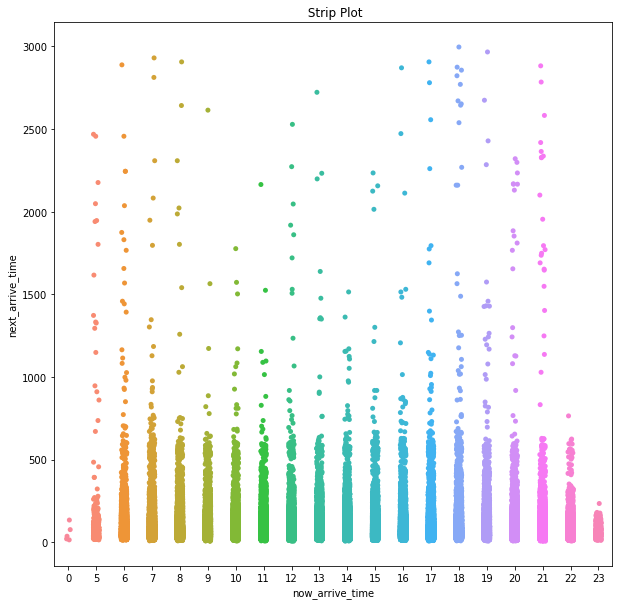

In [8]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

# 출발 시간에 따른 도착시간 분포 확인
plt.rcParams["figure.figsize"]=(10, 10)
sns.stripplot(x="now_arrive_time", y="next_arrive_time", data=train_df, jitter=True)
plt.title(" Strip Plot")
plt.show()

In [9]:
# 도착시간 1000초 이상의 이상치 데이터 제거
drop_index = train_df[train_df['next_arrive_time'] > 1000].index
print('이상치 개수: ', len(drop_index))
train_df.drop(drop_index, axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)

이상치 개수:  200


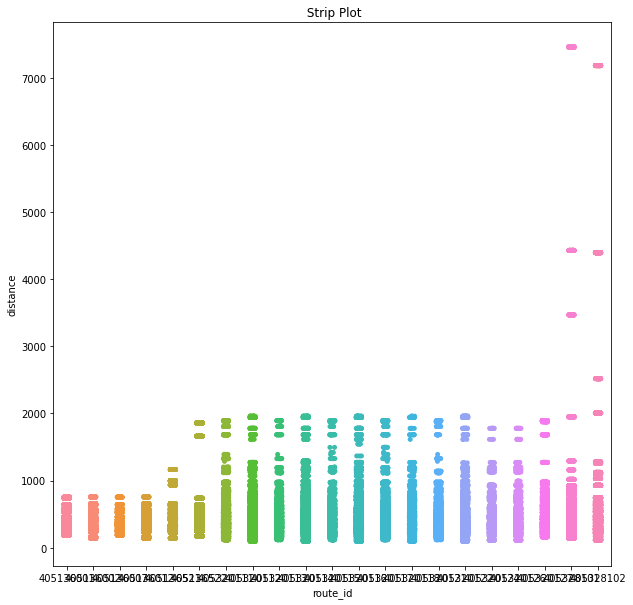

In [10]:
# 노선id에 따른 도착시간 분포 확인
plt.rcParams["figure.figsize"]=(10, 10)
sns.stripplot(x="route_id", y="distance", data=train_df, jitter=True)
plt.title(" Strip Plot")
plt.show()

In [11]:
# distance가 2500m 이상의 이상치 데이터 제거
drop_index = train_df[train_df['distance'] > 2500].index
print('이상치 개수: ', len(drop_index))
train_df.drop(drop_index, axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)

이상치 개수:  1580


## **지도시각화**

In [13]:
long_m = train_df['now_longitude'].mean()
lat_m = train_df['now_latitude'].mean()

In [14]:
tdf_sample= train_df.sample(20000)
tdf_sample.index

Int64Index([160443, 194108,  29300,  53946,  36671, 116399,  18294,  52498,
            175274,  36798,
            ...
            102539,  98562,  13389,  39967,  26894,  39183, 115183,  69576,
            190517, 104102],
           dtype='int64', length=20000)

In [ ]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map([lat_m, long_m],zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i in tdf_sample.index:
  sub_lat = tdf_sample.loc[i, "now_latitude"]
  sub_long = tdf_sample.loc[i, "now_longitude"]

  folium.CircleMarker(
      [sub_lat,sub_long ], 
      radius=5,
      color="blue",).add_to(marker_cluster)

m

##**K-means Clustering**
1. sample데이터로 최적의 군집화 개수를 먼저 찾기.

In [15]:
# 현재 위도, 경도 칼럼만 추출하여 DataFrame만들기
sample_now_df = tdf_sample.loc[:, ['now_longitude', 'now_latitude']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(sample_now_df)
sample_now_scaled = scaler.transform(sample_now_df)

sample_now_df_scaled = pd.DataFrame(data = sample_now_scaled, columns =['now_longitude', 'now_latitude'] )

In [ ]:
#visualize_silhouette()함수는 군집 개수를 변화시키면서 k-평균 군집을 
#시행했을때 개별 군집별 평균 실루엣 계수값을 시각화해서 군집의 개수를 정하는데 도움을 줌
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

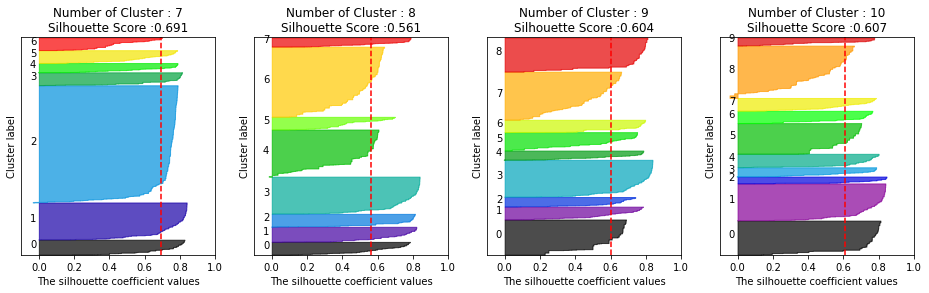

In [ ]:
#군집 개수가 7개, 8개, 9, 10 일 때의 군집별 실루엣 계수 평균값을 시각화
visualize_silhouette([7,8,9,10],sample_now_df_scaled)

2. cluster개수를 9로 설정하고 21만개의 원본데이터로 K-Means 수행

In [16]:
# 현재 위도, 경도 칼럼만 추출하여 DataFrame만들기
train_now_df = train_df.loc[:, ['now_longitude', 'now_latitude']]

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_now_df)
train_now_scaled = scaler.transform(train_now_df)

train_now_df_scaled = pd.DataFrame(data = train_now_scaled, columns =['now_longitude', 'now_latitude'] )

In [18]:
from sklearn.cluster import KMeans

# K-Means 클러스터링 수행
kmeans = KMeans(n_clusters = 9, init='k-means++', max_iter=300, random_state=0)
kmeans.fit_predict(train_now_df_scaled)

array([5, 5, 5, ..., 2, 2, 2], dtype=int32)

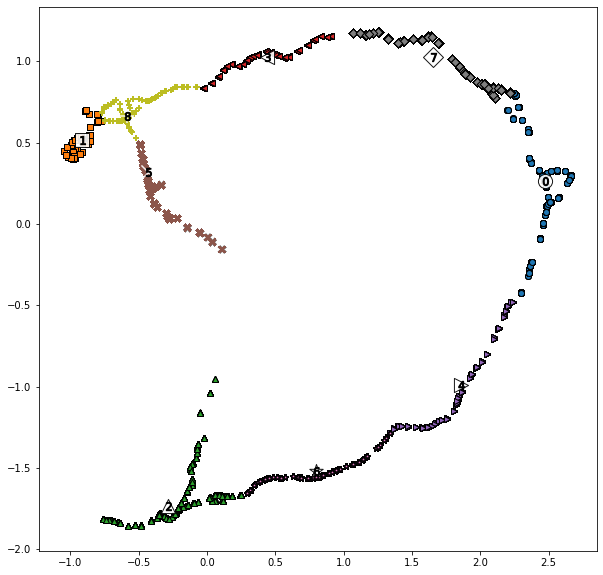

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"]=(10, 10)
train_now_df_scaled['cluster'] = kmeans.labels_

# cluster_centers_는 개별 클러스터의 중심 위치 좌표 시각화를 위해 추출
centers = kmeans.cluster_centers_
unique_labels = np.unique(kmeans.labels_)
markers = ['o', 's', '^', '<', '>', 'x', '*', 'D', '+']

# 군집된 label 유형별로 scatter plot시행
for label in unique_labels:
  label_cluster = train_now_df_scaled[train_now_df_scaled['cluster']==label]
  center_x_y = centers[label]
  plt.scatter(x=label_cluster['now_longitude'], y=label_cluster['now_latitude'], edgecolor='k', marker=markers[label])

  # 군집별 중심위치
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white', alpha=0.9, edgecolor='k', marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
plt.show()

In [20]:
train_now_df_scaled['cluster'].value_counts()

8    46695
2    35495
1    33825
5    33285
3    14027
6    12359
0    12304
7    11805
4     8882
Name: cluster, dtype: int64

In [21]:
# 위도, 경도로 군집화 한 결과를 원본 데이터 컬럼에 추가
train_df['cluster'] = train_now_df_scaled['cluster']
train_df.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,cluster
0,0,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24,5
1,1,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36,5
2,2,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40,5
3,3,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,5
4,4,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64,1


## **One-hot Encoding**

범주형 변수 원핫 인코딩 ( rout_nm, cluster )


In [51]:
# route_nm 버스 노선 값 확인
train_df['route_nm'].value_counts()

365-22    31918
281-2     24965
360-1     21665
281-1     18467
201-16    15450
201-14    12999
201-12    11871
365-21    11759
360-12     7989
201-11     7895
201-22     7723
360-2      7675
201-27     5950
201-17     5102
201-21     2670
201-26     2663
201-13     2631
201-18     2558
201-24     2368
201-15     2289
360-7      2070
Name: route_nm, dtype: int64

In [52]:
train_copy=train_df.copy()

In [53]:
# cluster 원핫인코딩
train_ohe= pd.get_dummies(train_copy, columns=['cluster'])

In [54]:
# route_nm 원핫인코딩
train_ohe= pd.get_dummies(train_ohe, columns=['route_nm'])
train_ohe

,id,route_id,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,route_nm_201-11,route_nm_201-12,route_nm_201-13,route_nm_201-14,route_nm_201-15,route_nm_201-16,route_nm_201-17,route_nm_201-18,route_nm_201-21,route_nm_201-22,route_nm_201-24,route_nm_201-26,route_nm_201-27,route_nm_281-1,route_nm_281-2,route_nm_360-1,route_nm_360-12,route_nm_360-2,route_nm_360-7,route_nm_365-21,route_nm_365-22
0,0,405136001,7997025,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,405136001,7997025,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,405136001,7997025,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,3,405136001,7997025,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,405136001,7997025,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208672,210452,405328102,7983486,33.255783,126.577450,비석거리,21,528.0,삼아아파트,33.251896,126.574417,96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
208673,210453,405328102,7983486,33.248595,126.568527,동문로터리,21,280.0,매일올레시장 7번입구,33.249753,126.565959,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
208674,210454,405328102,7983486,33.251891,126.560303,서귀포시 구 버스터미널,21,114.0,아랑조을거리 입구,33.251084,126.559551,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
208675,210455,405328102,7983486,33.251084,126.559551,아랑조을거리 입구,21,223.0,평생학습관,33.249504,126.558068,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [55]:
# now_arrive_time 원핫인코딩
train_ohe= pd.get_dummies(train_ohe, columns=['now_arrive_time'])
train_ohe

,id,route_id,vh_id,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,route_nm_201-11,route_nm_201-12,route_nm_201-13,route_nm_201-14,route_nm_201-15,route_nm_201-16,route_nm_201-17,route_nm_201-18,route_nm_201-21,route_nm_201-22,route_nm_201-24,route_nm_201-26,route_nm_201-27,route_nm_281-1,route_nm_281-2,route_nm_360-1,route_nm_360-12,route_nm_360-2,route_nm_360-7,route_nm_365-21,route_nm_365-22,now_arrive_time_0,now_arrive_time_5,now_arrive_time_6,now_arrive_time_7,now_arrive_time_8,now_arrive_time_9,now_arrive_time_10,now_arrive_time_11,now_arrive_time_12,now_arrive_time_13,now_arrive_time_14,now_arrive_time_15,now_arrive_time_16,now_arrive_time_17,now_arrive_time_18,now_arrive_time_19,now_arrive_time_20,now_arrive_time_21,now_arrive_time_22,now_arrive_time_23
0,0,405136001,7997025,33.456267,126.551750,제주대학교입구,266.0,제대마을,33.457724,126.554014,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,405136001,7997025,33.457724,126.554014,제대마을,333.0,제대아파트,33.458783,126.557353,36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,405136001,7997025,33.458783,126.557353,제대아파트,415.0,제주대학교,33.459893,126.561624,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,405136001,7997025,33.479705,126.543811,남국원(아라방면),578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,405136001,7997025,33.485662,126.494923,도호동,374.0,은남동,33.485822,126.490897,64,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208672,210452,405328102,7983486,33.255783,126.577450,비석거리,528.0,삼아아파트,33.251896,126.574417,96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208673,210453,405328102,7983486,33.248595,126.568527,동문로터리,280.0,매일올레시장 7번입구,33.249753,126.565959,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208674,210454,405328102,7983486,33.251891,126.560303,서귀포시 구 버스터미널,114.0,아랑조을거리 입구,33.251084,126.559551,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208675,210455,405328102,7983486,33.251084,126.559551,아랑조을거리 입구,223.0,평생학습관,33.249504,126.558068,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## **drop columns**

In [56]:
drop_columns = ['id', 'route_id', 'vh_id', 'now_station', 'next_station','now_arrive_time_0']
train_ohe.drop(drop_columns, axis=1, inplace=True)
train_ohe

,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,route_nm_201-11,route_nm_201-12,route_nm_201-13,route_nm_201-14,route_nm_201-15,route_nm_201-16,route_nm_201-17,route_nm_201-18,route_nm_201-21,route_nm_201-22,route_nm_201-24,route_nm_201-26,route_nm_201-27,route_nm_281-1,route_nm_281-2,route_nm_360-1,route_nm_360-12,route_nm_360-2,route_nm_360-7,route_nm_365-21,route_nm_365-22,now_arrive_time_5,now_arrive_time_6,now_arrive_time_7,now_arrive_time_8,now_arrive_time_9,now_arrive_time_10,now_arrive_time_11,now_arrive_time_12,now_arrive_time_13,now_arrive_time_14,now_arrive_time_15,now_arrive_time_16,now_arrive_time_17,now_arrive_time_18,now_arrive_time_19,now_arrive_time_20,now_arrive_time_21,now_arrive_time_22,now_arrive_time_23
0,33.456267,126.551750,266.0,33.457724,126.554014,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33.457724,126.554014,333.0,33.458783,126.557353,36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,33.458783,126.557353,415.0,33.459893,126.561624,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,33.479705,126.543811,578.0,33.484860,126.542928,42,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,33.485662,126.494923,374.0,33.485822,126.490897,64,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208672,33.255783,126.577450,528.0,33.251896,126.574417,96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208673,33.248595,126.568527,280.0,33.249753,126.565959,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208674,33.251891,126.560303,114.0,33.251084,126.559551,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208675,33.251084,126.559551,223.0,33.249504,126.558068,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


##**연속 변수 StandardScaling**

In [57]:
from sklearn.preprocessing import StandardScaler

col = ['now_latitude',	'now_longitude',	'distance',	'next_latitude',	'next_longitude'	]
scaler = StandardScaler()
train_df_scaled = train_ohe.copy()
train_df_scaled[col] = scaler.fit_transform(train_df_scaled[col]) 

train_df_scaled

,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,route_nm_201-11,route_nm_201-12,route_nm_201-13,route_nm_201-14,route_nm_201-15,route_nm_201-16,route_nm_201-17,route_nm_201-18,route_nm_201-21,route_nm_201-22,route_nm_201-24,route_nm_201-26,route_nm_201-27,route_nm_281-1,route_nm_281-2,route_nm_360-1,route_nm_360-12,route_nm_360-2,route_nm_360-7,route_nm_365-21,route_nm_365-22,now_arrive_time_5,now_arrive_time_6,now_arrive_time_7,now_arrive_time_8,now_arrive_time_9,now_arrive_time_10,now_arrive_time_11,now_arrive_time_12,now_arrive_time_13,now_arrive_time_14,now_arrive_time_15,now_arrive_time_16,now_arrive_time_17,now_arrive_time_18,now_arrive_time_19,now_arrive_time_20,now_arrive_time_21,now_arrive_time_22,now_arrive_time_23
0,0.207800,-0.415493,-0.681046,0.220585,-0.399613,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.222001,-0.397299,-0.437954,0.230919,-0.372754,36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.232323,-0.370467,-0.140439,0.241750,-0.338398,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.436239,-0.479291,0.450963,0.485382,-0.488789,42,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.494299,-0.872155,-0.289197,0.494769,-0.907326,64,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208672,-1.746221,-0.208967,0.269551,-1.787916,-0.235492,96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208673,-1.816279,-0.280673,-0.630251,-1.808827,-0.303528,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208674,-1.784154,-0.346761,-1.232537,-1.795839,-0.355074,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208675,-1.792020,-0.352804,-0.837060,-1.811257,-0.367003,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 예측 성능 평가 함수
캐글에서 요구한 성능 평가 방법 : RMSE(Root Mean Square Error)

+MAE, RMSLE까지 한꺼번에 평가하는 함수 추가작성

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가
회귀 모델 적용 전 처리할 사항

타겟 값 정규분포로 변환

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

y_target = train_df_scaled['next_arrive_time']
X_features = train_df_scaled.drop(['next_arrive_time'],axis=1,inplace=False) # inplace=False 주의

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

* next_arrive_time값이 왜곡됨
* 왜곡된 값 -> 정규분포로 바꾸는 방법은 "로그 변환"
* log1p()이용 후 학습 -> expm1()로 원상 복구

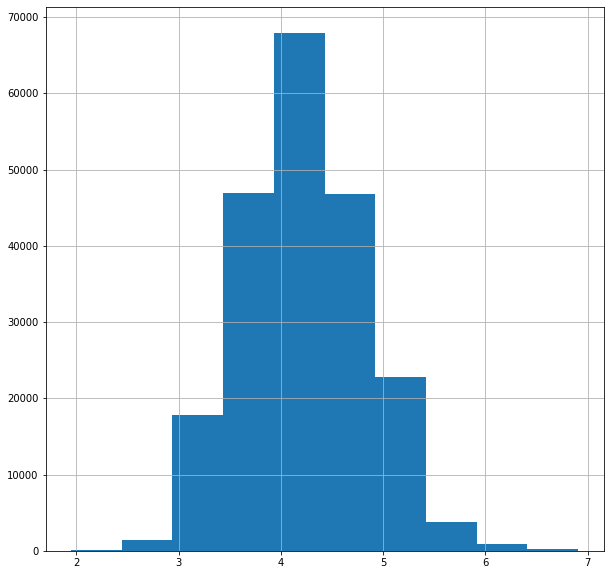

In [60]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [61]:
# 타겟 칼럼인 next_arrive_time값을 log1p로 로그변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

## **모델 학습**

In [62]:
# Linear Regression
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)
lr_pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target값이 로그 변환 됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값도 마찬가지
pred_exp = np.expm1(lr_pred)

print('Linear Regression RMSE :')
evaluate_regr(y_test_exp, lr_pred)

Linear Regression RMSE :
RMSLE: 2.638, RMSE: 97.223, MAE: 77.556


In [63]:
# XGB Regressor
xgb_reg = XGBRegressor(n_estimators=500, max_depth=5, random_state=0)
xgb_reg.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_pred = np.expm1(xgb_reg.predict(X_test))
print('XGBRegressor RMSE :')
evaluate_regr(y_test_exp, xgb_pred)

[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.40036	validation_1-rmse:3.40431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.06578	validation_1-rmse:3.06947
[2]	validation_0-rmse:2.76533	validation_1-rmse:2.76865
[3]	validation_0-rmse:2.49522	validation_1-rmse:2.49829
[4]	validation_0-rmse:2.2528	validation_1-rmse:2.25565
[5]	validation_0-rmse:2.03522	validation_1-rmse:2.03784
[6]	validation_0-rmse:1.84017	validation_1-rmse:1.84267
[7]	validation_0-rmse:1.66529	validation_1-rmse:1.66775
[8]	validation_0-rmse:1.50867	validation_1-rmse:1.51107
[9]	validation_0-rmse:1.36879	validation_1-rmse:1.37108
[10]	validation_0-rmse:1.24388	validation_1-rmse:1.24609
[11]	validation_0-rmse:1.13244	validation_1-rmse:1.13457
[12]	validation_0-rmse:1.03285	validatio

## **Test Data 동일 작업**

In [64]:
test_df = pd.read_csv('test.csv')


# now_arrive_time 을 int형으로 변경
test_df['now_arrive_time']=test_df.now_arrive_time.str.split('시').str[0]
test_df['now_arrive_time']=pd.to_numeric(test_df['now_arrive_time'])

test_df.drop('date', axis=1,inplace=True)

# 현재 위도, 경도 칼럼만 추출하여 DataFrame만들기
test_now_df = test_df.loc[:, ['now_longitude', 'now_latitude']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(test_now_df)
test_now_scaled = scaler.transform(test_now_df)

test_now_df_scaled = pd.DataFrame(data = test_now_scaled, columns =['now_longitude', 'now_latitude'] )

from sklearn.cluster import KMeans

# K-Means 클러스터링 수행
kmeans = KMeans(n_clusters = 9, init='k-means++', max_iter=300, random_state=0)
kmeans.fit_predict(test_now_df_scaled)
test_now_df_scaled['cluster'] = kmeans.labels_

# 위도, 경도로 군집화 한 결과를 원본 데이터 컬럼에 추가
test_df['cluster'] = test_now_df_scaled['cluster']

# one-hot encoding
test_copy=test_df.copy()

# cluster 원핫인코딩
test_ohe= pd.get_dummies(test_copy, columns=['cluster'])

# route_nm 원핫인코딩
test_ohe= pd.get_dummies(test_ohe, columns=['route_nm'])

# now_arrive_time 원핫인코딩
test_ohe= pd.get_dummies(test_ohe, columns=['now_arrive_time'])

# drop columns
drop_columns = ['route_id', 'vh_id', 'now_station', 'next_station']
test_ohe.drop(drop_columns, axis=1, inplace=True)

# 연속변수 StandardScaling
from sklearn.preprocessing import StandardScaler

col = ['now_latitude','now_longitude','distance','next_latitude','next_longitude']
scaler = StandardScaler()
test_df_scaled = test_ohe.copy()
test_df_scaled[col] = scaler.fit_transform(test_df_scaled[col]) 

In [65]:
test_df_scaled.head()

,id,now_latitude,now_longitude,distance,next_latitude,next_longitude,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,route_nm_201-11,route_nm_201-12,route_nm_201-13,route_nm_201-14,route_nm_201-15,route_nm_201-16,route_nm_201-17,route_nm_201-18,route_nm_201-21,route_nm_201-22,route_nm_201-24,route_nm_201-26,route_nm_201-27,route_nm_281-1,route_nm_281-2,route_nm_360-1,route_nm_360-12,route_nm_360-2,route_nm_360-7,route_nm_365-21,route_nm_365-22,now_arrive_time_5,now_arrive_time_6,now_arrive_time_7,now_arrive_time_8,now_arrive_time_9,now_arrive_time_10,now_arrive_time_11,now_arrive_time_12,now_arrive_time_13,now_arrive_time_14,now_arrive_time_15,now_arrive_time_16,now_arrive_time_17,now_arrive_time_18,now_arrive_time_19,now_arrive_time_20,now_arrive_time_21,now_arrive_time_22,now_arrive_time_23
0,210457,0.203817,-0.378658,-0.298636,0.212199,-0.354310,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,210458,0.214266,-0.351706,-0.131791,0.223165,-0.319795,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,210459,0.412433,-0.945152,-0.127721,0.410449,-0.911936,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,210460,0.412265,-0.908691,-0.296601,0.428726,-0.899143,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,210461,0.430519,-0.895913,0.142893,0.442330,-0.936139,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
X_features = test_df_scaled.drop(['id'],axis=1,inplace=False) 
test = test_df_scaled[list(X_features.columns)]
result = np.expm1(xgb_reg.predict(test))

# submission 파일 작성
submission = pd.read_csv('submission_제출양식.csv')
submission['next_arrive_time'] = result
submission.head()

,id,next_arrive_time
0,210457,46.227852
1,210458,47.467812
2,210459,181.995789
3,210460,68.719803
4,210461,106.767487


In [74]:
submission.to_csv('/content/gdrive/My Drive/Colab Notebooks/DACON/data/jeju_bus_result.csv', index=False)